# Yahoo Fantasy Football predictions

We merge a yahoo fantasy dataset with player's individual statistics and scoring with the NFL's dataset on team offensive performance.  We find the most relevant factors with PCA and then run deep learning to predict the best performing players.

In [232]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [111]:
!wget --no-check-certificate "https://onedrive.live.com/download?cid=49F92286A8610A74&resid=49F92286A8610A74%217438&authkey=AMfg9XuiLzO6-jU" -O ff_yahoo.csv

--2018-12-03 21:55:13--  https://onedrive.live.com/download?cid=49F92286A8610A74&resid=49F92286A8610A74%217438&authkey=AMfg9XuiLzO6-jU
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nd0pha.db.files.1drv.com/y4mmRRX2fRbvhhE4Tz29AzotI1gu-D_kIf6w5_cwe0agycCUlEMIcEVFxa-rRUcKvB1ksHkNT1Q9nmOGTnQPNXBaySEjC7xPYt1kQl__iBzxRILQsRfriXTYKsHFDIBhD5pJIykeuFe1EVRm8uaXf1pK2z5gFeq7xx-x2ejosp_TZK5D1t-pi7TY_b7lU_OvRKp8oEBttacModzFxkBl32l7Q/ff_yahoo.csv?download&psid=1 [following]
--2018-12-03 21:55:14--  https://nd0pha.db.files.1drv.com/y4mmRRX2fRbvhhE4Tz29AzotI1gu-D_kIf6w5_cwe0agycCUlEMIcEVFxa-rRUcKvB1ksHkNT1Q9nmOGTnQPNXBaySEjC7xPYt1kQl__iBzxRILQsRfriXTYKsHFDIBhD5pJIykeuFe1EVRm8uaXf1pK2z5gFeq7xx-x2ejosp_TZK5D1t-pi7TY_b7lU_OvRKp8oEBttacModzFxkBl32l7Q/ff_yahoo.csv?download&psid=1
Resolving nd0pha.db.files.1drv.com (nd0pha.db.files.1drv.com

## Week 1 Assignment

1. Identify quality issues (e.g. missing values, wrong measurements, …)

1. Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)

1. Get an idea on the value distribution of your data using statistical measures and visualizations

In [139]:
df_yahoo = pd.read_csv("ff_yahoo.csv")
df_nfl = pd.read_csv("NFL_team_stats.csv")

### 1. Quality Issues

In [140]:
# Data fixes
# Yahoo is inconsistent with JAX or JAC
df_yahoo.Team = ['JAX' if x == 'Jac' else x for x in df_yahoo.Team]
# Yahoo abbreiviated Rams only LA in 2015 because they were the only team in LA then
df_yahoo.Team = ['LAR' if x == 'LA' else x for x in df_yahoo.Team]
# The Rams moved from St Louis (STL) to Los Angeles in 2015 (LAR). NFL has renamed all years to LAR.  Update yahoo to keep consistent
df_yahoo.Team = ['LAR' if x == 'StL' else x for x in df_yahoo.Team]
# The Chargers moved from San Diego (SD) to Los Angeles in 2016 (LAC). NFL has renamed all years to LAC.  Update yahoo to keep consistent
df_yahoo.Team = ['LAC' if x == 'SD' else x for x in df_yahoo.Team]
# Some Posn labels have a leading space
df.Posn = [x.strip() for x in df.Posn]

df_yahoo.Team = df_yahoo.Team.str.upper()
df_yahoo.set_index(['Season', 'Team'], inplace=True)
df_yahoo.head()

Name Posn Owner  GP Fan_Pts  %_Owned  Proj Actual  \
Season Team                                                                 
2014   SEA    Marshawn Lynch   RB    FA  16     253      1.0   1.0      8   
       KC     Jamaal Charles   RB    FA  15     200      1.0   2.0     26   
       GB         Eddie Lacy   RB    FA  16     216      1.0   3.0     19   
       MIN   Adrian Peterson   RB    FA   1       8      1.0   4.0   1621   
       PIT      Le'Veon Bell   RB    FA  16     284      1.0   5.0      4   

            Pass_Yds Pass_TD   ...    Rushing_Att Rushing_Yds Rushing_TD  \
Season Team                    ...                                         
2014   SEA         0       0   ...            280        1306         13   
       KC          0       0   ...            206        1033          9   
       GB          0       0   ...            246        1139          9   
       MIN         0       0   ...             21          75          0   
       PIT         0       0   ...            290        1361          8   

            Rec_Tgt Rec_Receptions Rec_Yds Rec_TD Ret_TD 2PT Fum_Lost  
Season Team                                                            
2014   SEA       48             37     367      4      0   0        2  
       KC        59             40     291      5      0   0        3  
       GB        55             42     427      4      0   0        2  
       MIN        3              2      18      0      0   0        0  
       PIT      105             83     854      3      0   0        0  

[5 rows x 21 columns]

In [141]:
df_nfl.rename(columns={'Year':'Season', 'Team':'Team_Long', 'Team_Short':'Team'}, inplace=True)
df_nfl.set_index(['Season', 'Team'], inplace=True)
df_nfl.head()

Rk             Team_Long   G  Pts/G  TotPts  Scrm Plys  Yds/G  \
Season Team                                                                  
2012   NE     1  New England Patriots  16   34.8     557       1191  427.9   
       NO     2    New Orleans Saints  16   28.8     461       1067  410.9   
       DET    3         Detroit Lions  16   23.2     372       1160  408.8   
       DEN    4        Denver Broncos  16   30.1     481       1090  397.9   
       WAS    5   Washington Redskins  16   27.2     436        994  383.2   

             Yds/P  1st/G  3rd Md ...  3rd Pct  4th Md  4th Att  4th Pct  Pen  \
Season Team                       ...                                           
2012   NE      5.7   27.8     110 ...       49       8       12       67   97   
       NO      6.2   22.0      91 ...       44       8       14       57  104   
       DET     5.6   23.9      97 ...       42       6       15       40  103   
       DEN     5.8   23.8      96 ...       45       3        5       60  100   
       WAS     6.2   21.3      68 ...       36      12       17       71  116   

             Pen Yds  ToP/G FUM  Lost  TO  
Season Team                                
2012   NE        840  30:56  14     7  25  
       NO        911  28:59  13     5   2  
       DET       944  32:05  24    16 -16  
       DEN       805  31:16  22    14  -1  
       WAS       985  31:12  26     6  17  

[5 rows x 21 columns]

In [236]:
df = df_yahoo.join(df_nfl, how='left')

In [237]:
# convert data types
cols = df.columns.drop(['Name','Posn','Owner', 'Team_Long', 'ToP/G'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [238]:
# Change the dataframe with columns of object type to string
# Allows spark to create a dataframe from pandas df 
cols = ['Name', 'Posn', 'Owner', 'Team_Long', 'ToP/G']
for c in cols:
    df[c] = [str(x) for x in df[c]]

In [273]:
df = df.reset_index()

**1b. Convert to Spark Dataframe / RDD**

In [199]:
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
SparkSession.builder.config(conf=SparkConf())

In [274]:
sdf = sqlContext.createDataFrame(df)
rdd = sdf.rdd

In [275]:
sdf.createOrReplaceTempView("sdf")

In [276]:
# Take only player with at least 50 points.  We assume these players are the starters and/or significant substitutes
filtered = spark.sql('''SELECT * from sdf 
          WHERE Fan_Pts >= 50
          AND Fan_Pts!="NaN"
          ''')
filtered.createOrReplaceTempView("filtered")

In [278]:
# We note that there are a different number of entries per year, though the number of total Fantasy points counted up are all in the same ballpark.
spark.sql('''
SELECT SUM(Fan_Pts), COUNT(Fan_Pts)
FROM filtered
GROUP BY Season
''').show()

+------------------+--------------+
|      sum(Fan_Pts)|count(Fan_Pts)|
+------------------+--------------+
|           26501.0|           198|
|           26235.0|           190|
|29857.699999999983|           220|
| 28054.90000000001|           194|
|           24220.0|           178|
|25067.059999999994|           199|
|           20588.0|           131|
| 29338.25000000003|           207|
|           24382.0|           184|
|           27556.0|           206|
+------------------+--------------+



In [291]:
# We take a sample of the data to visualize, pretending that there is more data than can fit in one node
filtered_sample = spark.sql('''
SELECT Fan_Pts
FROM filtered
''')
filtered_sample = filtered_sample.sample(fraction=0.9, withReplacement=False)

{'boxes': [<matplotlib.lines.Line2D at 0x7fdb372319b0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fdb37235400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb372410b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb37235c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fdb37231b00>,
  <matplotlib.lines.Line2D at 0x7fdb37231f98>]}

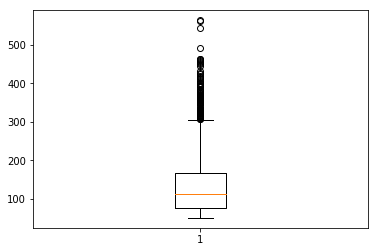

In [292]:
plt.boxplot(np.array(filtered_sample.collect()).astype(np.float))

(array([ 177.,  166.,  141.,  151.,  110.,  118.,  104.,   83.,   81.,
          70.,   60.,   42.,   44.,   33.,   36.,   38.,   25.,   28.,
          18.,   12.,   13.,   10.,   21.,   12.,   16.,   18.,   11.,
          12.,    4.,   12.,    6.,    7.,    6.,    6.,    3.,    4.,
           2.,    1.,    2.,    4.,    2.,    0.,    1.,    0.,    0.,
           0.,    0.,    1.,    0.,    2.]),
 array([  50.  ,   60.28,   70.56,   80.84,   91.12,  101.4 ,  111.68,
         121.96,  132.24,  142.52,  152.8 ,  163.08,  173.36,  183.64,
         193.92,  204.2 ,  214.48,  224.76,  235.04,  245.32,  255.6 ,
         265.88,  276.16,  286.44,  296.72,  307.  ,  317.28,  327.56,
         337.84,  348.12,  358.4 ,  368.68,  378.96,  389.24,  399.52,
         409.8 ,  420.08,  430.36,  440.64,  450.92,  461.2 ,  471.48,
         481.76,  492.04,  502.32,  512.6 ,  522.88,  533.16,  543.44,
         553.72,  564.  ]),
 <a list of 50 Patch objects>)

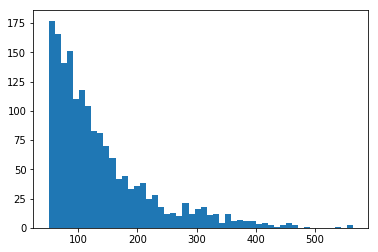

In [294]:
plt.hist(np.array(filtered_sample.collect()).astype(np.float), bins=50)

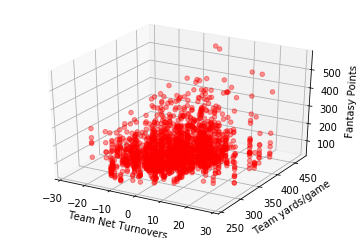

In [305]:
# How do individual player's points vary with team stats, such as yards per game and turnovers
result_fan_pts = np.array(spark.sql('''SELECT Fan_Pts FROM filtered''').collect()).astype(np.float)
result_yds_g = np.array(spark.sql('''SELECT `Yds/G` FROM filtered''').collect()).astype(np.float)
result_to = np.array(spark.sql('''SELECT TO FROM filtered''').collect()).astype(np.float)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_to,result_yds_g,result_fan_pts, c='r', marker='o', alpha=0.4)

ax.set_xlabel('Team Net Turnovers')
ax.set_ylabel('Team yards/game')
ax.set_zlabel('Fantasy Points')

plt.show()

### 2. Feature Quality

Feature engineering
1. Pick the most relevant fields to player performance
1. Aggregate fields to stats relevant for player performance.  In this case, team stats are already aggregate for the season year
1. Use PCA to find the most relevant fields and reduce dimensionality

In [334]:
from pyspark.ml.feature import PCA
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [224]:
# these are the Fan_Pts and owned from yahoo player stats, and all numeric fields from pts/g from the nfl team stats
data = rdd.map(lambda x: (x[4], x[5], x[24], x[25], x[26], x[27], x[28], x[29], x[30], x[31], x[32], x[33], x[34], x[35], x[36], x[37], x[39], x[40], x[41]))

In [225]:
type(data)

pyspark.rdd.PipelinedRDD

In [314]:
data = spark.sql("""
SELECT Fan_Pts,`%_Owned`,`Pts/G`,`Scrm Plys`,`Yds/G`,`1st/G`,`3rd Pct`,`4th Pct`,Pen,`Pen Yds`,FUM,Lost,TO
FROM filtered
WHERE
Fan_Pts != "NaN"
AND `%_Owned` != "NaN"
AND `Pts/G` != "NaN"
AND `Scrm Plys` != "NaN"
AND `Yds/G` != "NaN"
AND `1st/G` != "NaN"
AND `3rd Pct` != "NaN"
AND `4th Pct` != "NaN"
AND Pen != "NaN"
AND `Pen Yds` != "NaN"
AND FUM != "NaN"
AND Lost != "NaN"
AND TO != "NaN"
""")

In [332]:
data_vec = data.rdd.map( lambda x: (x[0], x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12]))

In [331]:
# View the correlation matrix
Statistics.corr(data_vec)

array([[  1.00000000e+00,   4.94619577e-01,   1.87034408e-01,
          7.18940523e-02,   1.70958590e-01,   1.53998632e-01,
          1.46871964e-01,   3.96035462e-02,  -5.12564598e-02,
         -5.38845732e-02,  -8.71207947e-02,  -5.27625428e-02,
          1.15010350e-01],
       [  4.94619577e-01,   1.00000000e+00,   1.85354920e-01,
          5.29330690e-02,   1.65266232e-01,   1.50724762e-01,
          1.71830230e-01,   4.14868621e-02,  -6.58995797e-02,
         -8.05671058e-02,  -8.40164183e-02,  -5.25081445e-02,
          1.08599446e-01],
       [  1.87034408e-01,   1.85354920e-01,   1.00000000e+00,
          4.20964256e-01,   8.29095259e-01,   7.73852986e-01,
          6.67539109e-01,   2.18374300e-01,  -6.04365661e-02,
         -2.06310101e-02,  -4.02329012e-01,  -2.59531218e-01,
          6.10189904e-01],
       [  7.18940523e-02,   5.29330690e-02,   4.20964256e-01,
          1.00000000e+00,   5.96210440e-01,   7.22493209e-01,
          4.94230379e-01,   2.07668355e-01,  -3.908

**PCA**

In [336]:
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")

In [337]:
features = assembler.transform(data)

In [341]:
features.rdd.map(lambda r: r.features).take(10)

[DenseVector([216.0, 1.0, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([166.0, 0.99, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([353.0, 0.99, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([112.0, 0.83, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([112.0, 0.45, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([68.0, 0.03, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([64.0, 0.02, 23.4, 985.0, 344.4, 19.8, 36.0, 56.0, 108.0, 886.0, 32.0, 18.0, -7.0]),
 DenseVector([280.0, 1.0, 22.7, 1048.0, 340.4, 20.6, 42.0, 70.0, 78.0, 664.0, 19.0, 8.0, 3.0]),
 DenseVector([175.0, 0.99, 22.7, 1048.0, 340.4, 20.6, 42.0, 70.0, 78.0, 664.0, 19.0, 8.0, 3.0]),
 DenseVector([158.0, 0.99, 22.7, 1048.0, 340.4, 20.6, 42.0, 70.0, 78.0, 664.0, 19.0, 8.0, 3.0])]

In [342]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [343]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-896.1047721137464,-370.32012402489966,-950.335000265916]  |
|[-898.3160823298438,-320.85991731725903,-956.907697031125]  |
|[-890.0457915424804,-505.84100178013637,-932.3258089324331] |
|[-900.7043349458343,-267.44254052606004,-964.0062007738054] |
|[-900.7044306656068,-267.44164007136885,-964.0061784532738] |
|[-902.650487234642,-223.9156837818846,-969.7901274534931]   |
|[-902.8273943693559,-219.95884544479136,-970.3159426543182] |
|[-670.1103444665669,-429.4693773688426,-997.6476351654034]  |
|[-674.7540931495357,-325.60296934859093,-1011.4502990184628]|
|[-675.5059377665688,-308.786507124693,-1013.685016118344]   |
|[-672.1005339887141,-384.955094177644,-1003.5630598458237]  |
|[-677.8943364811595,-255.36775595528115,-1020.7834857928449]|
|[-678.4691858005302,-242.5089614346394,-1022.492408250

In [358]:
sample_pca = result_pca.rdd.sample(False,0.2)

In [359]:
x = sample_pca.map(lambda a: a.pcaFeatures).map(lambda a: a[0]).collect()
y = sample_pca.map(lambda a: a.pcaFeatures).map(lambda a: a[1]).collect()
z = sample_pca.map(lambda a: a.pcaFeatures).map(lambda a: a[2]).collect()

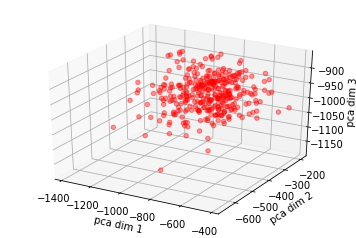

In [360]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, c='r', marker='o', alpha=0.4)

ax.set_xlabel('pca dim 1')
ax.set_ylabel('pca dim 2')
ax.set_zlabel('pca dim 3')

plt.show()

The center is a bit more densely packed but there is a wide dispersion for the points.